# Topic Modeling my iMessage conversations

In this notebook, I'll be building a topic model using messages I've sent in the past year. I collected this data by downloading the data from `chat.db`. I followed Dan Kelch's [helpful tutorial](https://spin.atomicobject.com/2020/05/22/search-imessage-sql/) to get access to the `chat.db` and then used the code in `collect_imessage_data.py` (found in the src folder) to export each table as a csv.

I'll be using the `message` table in this analysis, since it's the table that contains all the messages I've sent and recieved, along with interesting metadata. I'll only be using my messages, and any messages sent to me from others will be excluded to maintain their privacy.

In [8]:
import pandas as pd
import html

In [134]:
data = pd.read_csv("../data/raw/message.csv", low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11889 entries, 0 to 11888
Data columns (total 74 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ROWID                              11889 non-null  int64  
 1   guid                               11889 non-null  object 
 2   text                               11486 non-null  object 
 3   replace                            11889 non-null  int64  
 4   service_center                     0 non-null      float64
 5   handle_id                          11889 non-null  int64  
 6   subject                            4 non-null      object 
 7   country                            0 non-null      float64
 8   attributedBody                     11486 non-null  object 
 9   version                            11889 non-null  int64  
 10  type                               11889 non-null  int64  
 11  service                            11889 non-null  obj

In [135]:
text = data.query('is_from_me == 1')['text'].apply(html.unescape).values
text

array(['Argh, that’d be fun but we’re going to Nashville to see our niece this weekend',
       'Maybe next weekend? OOO or if you and chris are down we can try to rent some Kayaks?',
       '￼', ..., 'Yeah gimme 15', 'Getting on',
       'Good! Uneventful LOL how’s yours?'], dtype=object)

In [136]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text, show_progress_bar=True)

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

In [142]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=50, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [169]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

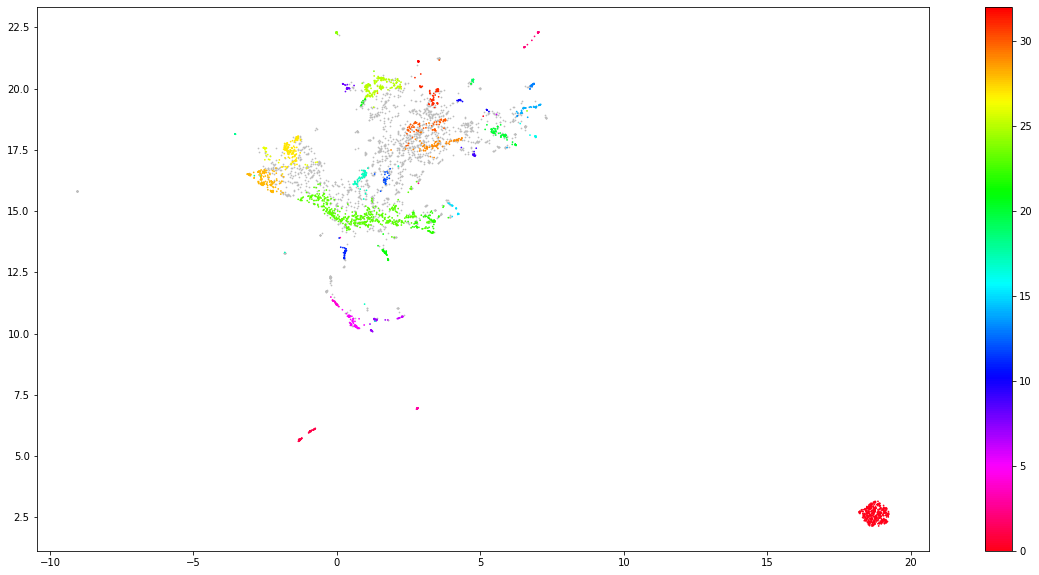

In [215]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [214]:
for c in set(cluster.labels_):
    if c == -1:
        continue
    top_idx = exemplars = [np.where(np.all(umap_embeddings == cluster.exemplars_[c][i], axis=1) == True)[0][0] for i in range(5)]
    print("Representative messages for cluster {}".format(c))
    print('=====================================')
    for idx in top_idx:
        print(text[idx])
    print('\n\n')

Representative messages for cluster 0
￼
￼
￼
￼GTFO
￼



Representative messages for cluster 1
https://twitter.com/deafbeatdad/status/1299441304552779778?s=20
https://twitter.com/miakhalifa/status/1354518139615109121?s=20
https://twitter.com/0cks/status/1300952493610987520?s=20
https://twitter.com/deafbeatdad/status/1299441304552779778?s=20
https://twitter.com/StarrburyMike/status/1354444455886118915?s=20



Representative messages for cluster 2
Pex?
Pex?
Pex?
Pex?
Pex?



Representative messages for cluster 3
https://www.youtube.com/watch?v=UWNDLaAYBrQ
https://m.youtube.com/watch?v=v6P8QmDS0Q4
https://www.youtube.com/watch?v=zxC-UkdEI5E
https://m.youtube.com/watch?v=hx1mjT73xYE
https://www.youtube.com/watch?v=Sg7ZHGX0td4



Representative messages for cluster 4
https://www.npr.org/series/967404527/planet-money-buys-a-superhero
https://www.airbnb.com/rooms/43077205?location=Maryland&check_in=2020-09-11&check_out=2020-09-22&source_impression_id=p3_1597259261_5VANqo7mVtWweytO
https://www.a

In [49]:
label_df_2 = label_df\
.assign(tokens=lambda x: x['message'].str.replace(r'[^\w\s]', ' ').str.split())

<ipython-input-49-2a675cc4126a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(tokens=lambda x: x['message'].str.replace(r'[^\w\s]', ' ').str.split())


In [51]:
import collections

In [86]:
from sklearn.metrics.pairwise import cosine_similarity

In [99]:
umap_embeddings[0]



array([ 5.834969 , -8.203875 ,  3.7549188,  8.37324  ,  2.940854 ],
      dtype=float32)

In [101]:
list(umap_embeddings)

[array([ 5.834969 , -8.203875 ,  3.7549188,  8.37324  ,  2.940854 ],
       dtype=float32),
 array([ 5.62663  , -8.606379 ,  3.913155 ,  8.397904 ,  3.1631339],
       dtype=float32),
 array([-10.615208  ,   5.0327272 ,  11.126849  ,   3.567252  ,
         -0.02336221], dtype=float32),
 array([ 8.626797 , -7.0702696,  5.4386973,  8.153726 ,  3.7921314],
       dtype=float32),
 array([ 4.740915 , -7.7896805,  3.2079406,  8.363393 ,  4.128608 ],
       dtype=float32),
 array([ 6.2792425, -8.442133 ,  2.4987533,  9.147472 ,  2.6602738],
       dtype=float32),
 array([-10.719169  ,   5.0854545 ,  10.958127  ,   4.1212883 ,
         -0.24259834], dtype=float32),
 array([-10.262057  ,   5.091178  ,  10.837967  ,   4.0303364 ,
         -0.12191509], dtype=float32),
 array([  4.9495616, -10.447059 ,   2.7029731,  10.324573 ,   5.198792 ],
       dtype=float32),
 array([-10.178848  ,   4.9184046 ,  10.629115  ,   3.9385126 ,
         -0.11659203], dtype=float32),
 array([-10.126145  ,   5.23006

In [109]:
cosine_similarity?

In [119]:
import numpy as np

In [123]:
cluster.probabilities_[np.where(cluster.labels_==1)][11]

0.1069780076876235

In [125]:
cluster.probabilities_[np.where(cluster.labels_==1)].argsort()[::-1][:5]

array([30, 20,  5,  8,  9])

In [110]:
sims = cosine_similarity(umap_embeddings, cluster.exemplars_[0])
representatives = sims.argsort()[:5][::-1]


In [115]:
len(cluster.exemplars_[0])

120

In [111]:
len(sims)

4327

In [108]:
len(umap_embeddings)

4327

In [112]:
sims

array([[-0.13880376, -0.13222698, -0.13279585, ..., -0.10541279,
        -0.10905749, -0.10618836],
       [-0.12853588, -0.12202508, -0.1224323 , ..., -0.09443189,
        -0.09797551, -0.09510232],
       [ 0.9994456 ,  0.99929171,  0.99940216, ...,  0.99922505,
         0.99935667,  0.9992776 ],
       ...,
       [-0.13524726, -0.12941429, -0.12967409, ..., -0.09887235,
        -0.10231309, -0.09960434],
       [-0.19577774, -0.19084527, -0.19014046, ..., -0.15681369,
        -0.16006231, -0.1575176 ],
       [ 0.06516146,  0.07101836,  0.07151487, ...,  0.10244212,
         0.09916134,  0.1019491 ]])

In [105]:
representatives

array([[ 17,  15,  24,  20,  27,  25,  26,  22,  29,  28,  23,  16,  44,
         31,  19,  30,   0,  37,  18,  21,  35,  42,  76,   7,  36,  13,
         12,  11,  41,  14,  10,   4,   8,   6,   2,  32,   5,   1,   9,
         43,  39,  33,   3,  40,  34, 101,  38,  82,  88,  83,  86,  92,
        104,  96,  79,  95, 102,  77,  84, 100,  89,  80,  87,  91,  85,
         98,  78,  67,  70,  90,  93, 103,  99,  71,  64,  81,  97,  63,
         62,  94,  60,  75,  52,  50,  72,  74,  49,  51,  47,  59,  65,
         45,  54,  58,  69,  53,  48,  56,  46,  57,  55,  66,  73,  61,
         68, 105, 110, 118, 112, 113, 114, 116, 106, 119, 107, 115, 117,
        111, 108, 109],
       [ 17,  15,  24,  20,  27,  26,  22,  28,  29,  25,  23,  16,  19,
         21,  44,  18,  30,  76,  31,  37,   0, 101,  42, 102,  36, 104,
         82,  12,  35,  11,  32,  96,  13,  95,  41,   7,  88,  83,  14,
          4,  43,   2,  10,  92,  84,  86,   8,  33,  91,   9,   6,   5,
         79,  39, 100,  99,

In [82]:
for exemplar in cluster.exemplars_:
    cosine_similarity

41

In [63]:
pd.DataFrame(counter(tokens).most_common(5), columns=['word', 'count']).assign(cluster = cluster)

,word,count,cluster
0,the,5,16
1,NFL,3,16
2,I,3,16
3,to,3,16
4,at,2,16


In [57]:
tokens

['Nflbite',
 'bro',
 'Look',
 'at',
 'me',
 'NFL',
 'analyst',
 'right',
 'here',
 'got',
 'the',
 'score',
 'right',
 'I',
 'saw',
 'they',
 'scored',
 'did',
 'we',
 'punt',
 'you',
 'using',
 'nflbite',
 'I',
 'BROUGHT',
 'BACK',
 'FOOTBALL',
 'VOTE',
 'FOR',
 'ME',
 'Yeah',
 'that',
 'was',
 'a',
 'great',
 'run',
 'isn',
 't',
 'football',
 'fun',
 'Put',
 'Greg',
 'ward',
 'in',
 'at',
 'QB',
 'and',
 'have',
 'him',
 'throw',
 'the',
 'ball',
 'tho',
 'himself',
 'please',
 'Great',
 'TD',
 'pass',
 'RIP',
 'to',
 'the',
 'NFL',
 'season',
 'Fantasy',
 'football',
 'Yikes',
 'Comments',
 'on',
 'these',
 'NFL',
 'posts',
 'Trump',
 'waking',
 'up',
 'to',
 'see',
 'Georgia',
 'turned',
 'blue',
 'Former',
 'Super',
 'Bowl',
 'MVP',
 'Joe',
 'Flacco',
 'ALSO',
 'I',
 'heard',
 'the',
 'Jets',
 'are',
 'thinking',
 'about',
 'drafting',
 'that',
 'QB',
 'out',
 'of',
 'Syracuse',
 'Bro',
 'this',
 'guy',
 'got',
 'six',
 'touchdowns',
 'Wentz',
 'to',
 'the',
 'colts']

In [64]:
top_5_df = []

counter = collections.Counter
for cluster in label_df_2['cluster'].unique():
    tmp_data = label_df_2[label_df_2['cluster'] == cluster]
    tokens = [word for doc in tmp_data['tokens'].tolist() for word in doc]
    top_5_df.append(pd.DataFrame(counter(tokens).most_common(5), columns=['word', 'count']).assign(cluster = cluster))

In [69]:
pd.set_option('display.max_rows', 250)
pd.concat(top_5_df).reset_index(drop=True).sort_values('cluster')

,word,count,cluster
0,I,490,-1
1,the,378,-1
2,to,365,-1
3,you,308,-1
4,a,283,-1
14,ORDER,1,0
10,s,2,0
11,Also,2,0
12,You,1,0
13,DRAFT,1,0
